In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00


In [34]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.sparse import coo_matrix
import datetime
import random
import string
import scipy.io
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Batch,Data
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from torchsummary import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/final_coordinates.pkl','rb') as file:
    inp = pickle.load(file)
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/s_list.pkl','rb') as file:
    s = pickle.load(file)
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/z_list.pkl','rb') as file:
    z = pickle.load(file)
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/xi_list.pkl','rb') as file:
    xi = pickle.load(file)
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/xi_MF_list.pkl','rb') as file:
    ximf = pickle.load(file)

In [5]:
target = np.hstack((s,z,xi,ximf))
print(target.shape)

(40286, 4)


In [6]:
inp_train, inp_val, target_train, target_val = train_test_split(inp, target, test_size=0.2, random_state=69)
inp_train, inp_test, target_train, target_test = train_test_split(inp_train, target_train, test_size=0.2, random_state=69)

In [7]:
learning_rate = 0.0001
batch_size = 32
cutoff_radius = 10

In [8]:
def getDataLoader(x,y):
    tensor_inp = torch.Tensor(x)
    tensor_z = torch.Tensor(y)
    dataset = TensorDataset(tensor_inp,tensor_z)
    return DataLoader(dataset, batch_size)

In [9]:
train_dataloader = getDataLoader(inp_train, target_train)
val_dataloader = getDataLoader(inp_val, target_val)
test_dataloader = getDataLoader(inp_test, target_test)

In [10]:
def train(
    model,
    dataset,
    optimizer,
    loss,
    length_of_set,
    is_dev=False
):
    total_loss = 0
    y_pred, y_actual = [], []
    model.train()
    for x,y in tqdm(dataset):

        if not is_dev: optimizer.zero_grad()

        x = x.to(device) # (B, 3072, 3)
        y = y.to(device)  # (B, 2)
        num_atoms = x.shape[1]
        batch_size = x.shape[0]
        distances_matrix = torch.cdist(x,x,p=2)
        adjacency_matrix = (distances_matrix < cutoff_radius).float()
        edge_list = [torch.nonzero(adjacency_matrix[i], as_tuple=False).t() for i in range(batch_size)] # (B, 2, E)

        xDash = x.view(-1, 3)
        # edge_dash = torch.tensor([])
        for i in range(len(edge_list)):
          edge_list[i][0] = edge_list[i][0] + i*(num_atoms)
          edge_list[i][1] = edge_list[i][1] + i*(num_atoms)
          edge_list[i] = torch.transpose(edge_list[i], 0, 1)

        # print(len(edge_list), edge_list[0].shape)

        edge_dash = torch.transpose(torch.cat(edge_list), 0, 1).to(device)
        # print(edge_dash.shape)

        # max_l = max([edge_index.shape[1] for edge_index in edge_list])
        # edge_indexes = torch.zeros(batch_size,2,max_l, dtype=torch.int64).to(device)
        # for i, edge_index in enumerate(edge_list):
        #     edge_index_p = F.pad(edge_index, [0, max_l - edge_index.shape[1]], value=3073)
        #     edge_indexes[i,:,:] = edge_index_p


        pred = model(xDash, edge_dash, len(edge_list)) # (B, 1)
        curr_loss = loss(pred, y)
        # print(curr_loss.item())
        total_loss += curr_loss.item()*len(y)/(length_of_set)

        if not is_dev:
            curr_loss.backward()
            optimizer.step()

        y_pred += pred.flatten().tolist()
        y_actual += y.flatten().tolist()

    return total_loss

In [11]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.emb = nn.Linear(in_channels, hidden_channels)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        self.fc1 = nn.Linear(out_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, 1)
        self.fc3 = nn.Linear(3072,4)
    def forward(self, x, edge_index, B):
        # print(x.shape, edge_index.shape, B)
        x = self.emb(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        # x = F.relu(x) # (32* 3072, 3)
        # x = x.view(x.size(0), -1) # ()

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = x.view(B, 3072)
        x = self.fc3(x)
        x = torch.sigmoid(x) # (B, 2)
        return x

In [12]:
model = GCN(in_channels=3, hidden_channels=25, out_channels=25).to(device)
print(model)
loss = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.5 ** epoch)

GCN(
  (emb): Linear(in_features=3, out_features=25, bias=True)
  (conv1): GCNConv(25, 25)
  (conv2): GCNConv(25, 25)
  (fc1): Linear(in_features=25, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
  (fc3): Linear(in_features=3072, out_features=4, bias=True)
)


In [13]:
file_name = '/content/drive/MyDrive/Neural Network for Pore Formation/GNN/1shell_10.txt'

In [14]:
file = open(file_name, "a")
num_epochs = 10
losses = []
file.write(f"Batch Size: {batch_size}, Learning Rate: {learning_rate} \n")
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, loss, inp_train.shape[0])
    val_loss = train(model, val_dataloader, optimizer, loss, inp_val.shape[0], True)
    print(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss}')
    file.write(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss} \n')
    losses.append(val_loss)
    scheduler.step()
file.close()

100%|██████████| 252/252 [00:20<00:00, 12.33it/s]


Epoch: 1/10 train loss: 0.0064020876153337205 val_loss: 0.003544428843596188


100%|██████████| 252/252 [00:20<00:00, 12.28it/s]


Epoch: 2/10 train loss: 0.00326669013255054 val_loss: 0.0031871642921093104


100%|██████████| 252/252 [00:20<00:00, 12.37it/s]


Epoch: 3/10 train loss: 0.0029800904559250515 val_loss: 0.0030305151459866144


100%|██████████| 252/252 [00:20<00:00, 12.29it/s]


Epoch: 4/10 train loss: 0.002864765195895144 val_loss: 0.002941295585705334


100%|██████████| 252/252 [00:20<00:00, 12.35it/s]


Epoch: 5/10 train loss: 0.0028083341436361074 val_loss: 0.002901088871530119


100%|██████████| 252/252 [00:20<00:00, 12.29it/s]


Epoch: 6/10 train loss: 0.0027803671361330776 val_loss: 0.0028736942231476683


100%|██████████| 252/252 [00:20<00:00, 12.35it/s]


Epoch: 7/10 train loss: 0.0027660960504949485 val_loss: 0.002862085393875224


100%|██████████| 252/252 [00:20<00:00, 12.31it/s]


Epoch: 8/10 train loss: 0.002758990355170048 val_loss: 0.002856416558129326


100%|██████████| 252/252 [00:20<00:00, 12.34it/s]


Epoch: 9/10 train loss: 0.0027554270001826937 val_loss: 0.002853718216418408


100%|██████████| 252/252 [00:20<00:00, 12.29it/s]


Epoch: 10/10 train loss: 0.0027535091437011876 val_loss: 0.0028525318868470296


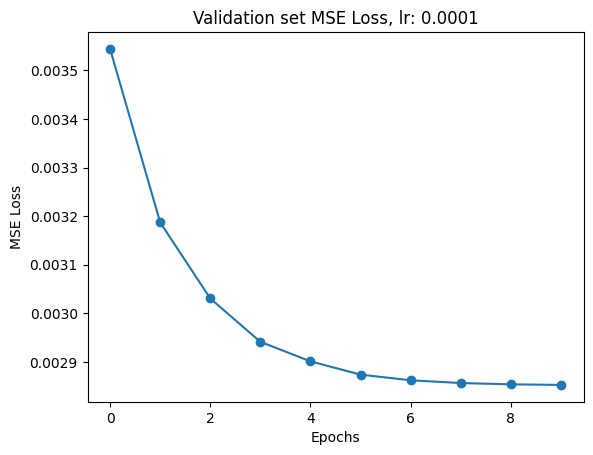

In [15]:
plt.plot(losses, marker='o')
plt.title(f"Validation set MSE Loss, lr: {learning_rate}")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.savefig(f'1shell_{cutoff_radius}_real_loss.png', bbox_inches='tight')

In [16]:
test_loss = train(model, test_dataloader, optimizer, loss, inp_train.shape[0], True)
print('test loss:',test_loss)

100%|██████████| 202/202 [00:16<00:00, 12.34it/s]

test loss: 0.0007185501622604096


In [17]:
out = []
for x,y in tqdm(test_dataloader):
    x = x.to(device)
    y = y.to(device)
    num_atoms = x.shape[1]
    distances_matrix = torch.cdist(x,x,p=2)
    adjacency_matrix = (distances_matrix < cutoff_radius).float()
    edge_list = [torch.nonzero(adjacency_matrix[i], as_tuple=False).t() for i in range(len(x))] # (B, 2, E)
    xDash = x.view(-1, 3)
    for i in range(len(edge_list)):
      edge_list[i][0] = edge_list[i][0] + i*(num_atoms)
      edge_list[i][1] = edge_list[i][1] + i*(num_atoms)
      edge_list[i] = torch.transpose(edge_list[i], 0, 1)
    edge_dash = torch.transpose(torch.cat(edge_list), 0, 1).to(device)
    outputs = model(xDash,edge_dash,len(edge_list))
    outputs = outputs.cpu().detach()
    outputs = outputs.numpy()
    out.extend(outputs)

100%|██████████| 202/202 [00:17<00:00, 11.31it/s]


In [18]:
for i in range(32):
    print(out[i], target_test[i])

[0.0758395  0.17958127 0.30522236 0.1719514 ] [0.09014342 0.19387671 0.3259924  0.19210718]
[0.52016956 0.18881328 0.39121708 0.28918362] [0.51307607 0.19428132 0.39908065 0.29317787]
[0.06899858 0.14508617 0.32023603 0.18240845] [0.08611583 0.16997177 0.32669484 0.19485397]
[0.48607492 0.39777365 0.34269667 0.28811508] [0.47888364 0.37321827 0.30547172 0.21716464]
[0.7458783  0.3320878  0.62026757 0.48621777] [0.74610018 0.28042199 0.60165039 0.49470262]
[0.42822075 0.23174405 0.32722488 0.23850936] [0.41287616 0.23778214 0.35367478 0.35999776]
[0.2905465  0.44082355 0.27883145 0.35215098] [0.27627078 0.50589437 0.20047501 0.34688043]
[0.3684694  0.24666663 0.35419667 0.31723964] [0.36909415 0.18228279 0.34116239 0.43578676]
[0.14021574 0.31144923 0.2581429  0.18616027] [0.13365446 0.2147687  0.25360659 0.13375189]
[0.09550728 0.21532893 0.30396742 0.21395831] [0.07533153 0.20744944 0.3258185  0.16340602]
[0.9287358  0.27342895 0.84642905 0.77365655] [0.87575893 0.2437725  0.7780479  

In [19]:
target_test_n = np.array(target_test)

In [20]:
out = np.array(out)
out.shape

(6446, 4)

R-squared for Dimension 1: 0.9922665633308955
Spearman rank correlation coefficient for Dimension 1: 0.995626589744194
Kendall rank correlation coefficient for Dimension 1: 0.94080258914851
Pearson rank correlation coefficient for Dimension 1: 0.9961271448847969
R-squared for Dimension 2: 0.7576798038574911
Spearman rank correlation coefficient for Dimension 2: 0.7522695371829443
Kendall rank correlation coefficient for Dimension 2: 0.5687414332749612
Pearson rank correlation coefficient for Dimension 1: 0.8706526794679568
R-squared for Dimension 3: 0.9492869251681783
Spearman rank correlation coefficient for Dimension 3: 0.9461021530021687
Kendall rank correlation coefficient for Dimension 3: 0.8182095540938898
Pearson rank correlation coefficient for Dimension 3: 0.9743878670893548
R-squared for Dimension 4: 0.9344870983652228
Spearman rank correlation coefficient for Dimension 4: 0.9249234294453009
Kendall rank correlation coefficient for Dimension 4: 0.7786610696373066
Pearson rank

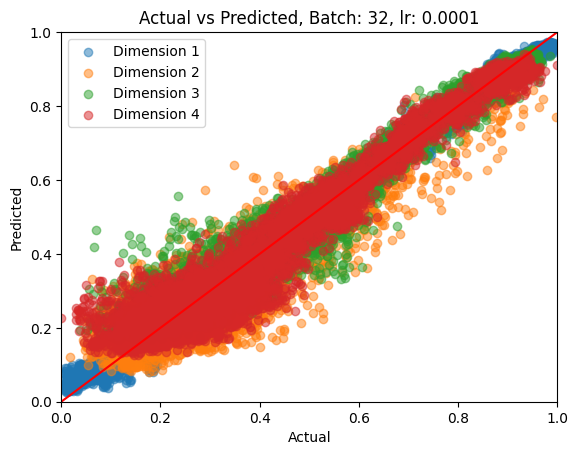

In [21]:
plt.scatter(target_test_n[:, 0], out[:, 0], label='Dimension 1', alpha=0.5)
plt.scatter(target_test_n[:, 1], out[:, 1], label='Dimension 2', alpha=0.5)
plt.scatter(target_test_n[:, 2], out[:, 2], label='Dimension 3', alpha=0.5)
plt.scatter(target_test_n[:, 3], out[:, 3], label='Dimension 4', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Actual vs Predicted, Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plotting a diagonal line for reference
p1 = max(out.max(), target_test_n.max())
p2 = min(out.min(), target_test_n.min())
plt.plot([p1, p2], [p1, p2], 'r-')

# Calculating R-squared for each dimension
R_square_dim1 = r2_score(target_test_n[:, 0], out[:, 0])
R_square_dim2 = r2_score(target_test_n[:, 1], out[:, 1])
R_square_dim3 = r2_score(target_test_n[:, 2], out[:, 2])
R_square_dim4 = r2_score(target_test_n[:, 3], out[:, 3])

# Printing correlation coefficients for each dimension
s_corr_dim1, _ = spearmanr(target_test_n[:, 0], out[:, 0])
s_corr_dim2, _ = spearmanr(target_test_n[:, 1], out[:, 1])
s_corr_dim3, _ = spearmanr(target_test_n[:, 2], out[:, 2])
s_corr_dim4, _ = spearmanr(target_test_n[:, 3], out[:, 3])

k_corr_dim1, _ = kendalltau(target_test_n[:, 0], out[:, 0])
k_corr_dim2, _ = kendalltau(target_test_n[:, 1], out[:, 1])
k_corr_dim3, _ = kendalltau(target_test_n[:, 2], out[:, 2])
k_corr_dim4, _ = kendalltau(target_test_n[:, 3], out[:, 3])

p_corr_dim1, _ = pearsonr(target_test_n[:, 0], out[:, 0])
p_corr_dim2, _ = pearsonr(target_test_n[:, 1], out[:, 1])
p_corr_dim3, _ = pearsonr(target_test_n[:, 2], out[:, 2])
p_corr_dim4, _ = pearsonr(target_test_n[:, 3], out[:, 3])

# Printing R-squared and correlation coefficients
print("R-squared for Dimension 1:", R_square_dim1)
print("Spearman rank correlation coefficient for Dimension 1:", s_corr_dim1)
print("Kendall rank correlation coefficient for Dimension 1:", k_corr_dim1)
print("Pearson rank correlation coefficient for Dimension 1:", p_corr_dim1)

print("R-squared for Dimension 2:", R_square_dim2)
print("Spearman rank correlation coefficient for Dimension 2:", s_corr_dim2)
print("Kendall rank correlation coefficient for Dimension 2:", k_corr_dim2)
print("Pearson rank correlation coefficient for Dimension 1:", p_corr_dim2)

print("R-squared for Dimension 3:", R_square_dim3)
print("Spearman rank correlation coefficient for Dimension 3:", s_corr_dim3)
print("Kendall rank correlation coefficient for Dimension 3:", k_corr_dim3)
print("Pearson rank correlation coefficient for Dimension 3:", p_corr_dim3)

print("R-squared for Dimension 4:", R_square_dim4)
print("Spearman rank correlation coefficient for Dimension 4:", s_corr_dim4)
print("Kendall rank correlation coefficient for Dimension 4:", k_corr_dim4)
print("Pearson rank correlation coefficient for Dimension 4:", p_corr_dim4)

# Save results to a file
file_name = 'results.txt'
with open(file_name, 'a') as file:
    file.write('\n')
    file.write(f"R-squared for Dimension 1: {R_square_dim1}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 1: {s_corr_dim1}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 1: {k_corr_dim1}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 1: {p_corr_dim1}\n")
    file.write(f"R-squared for Dimension 2: {R_square_dim2}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 2: {s_corr_dim2}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 2: {k_corr_dim2}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 2: {p_corr_dim2}\n")
    file.write(f"R-squared for Dimension 3: {R_square_dim3}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 3: {s_corr_dim3}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 3: {k_corr_dim3}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 3: {p_corr_dim3}\n")
    file.write(f"R-squared for Dimension 4: {R_square_dim4}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 4: {s_corr_dim4}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 4: {k_corr_dim4}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 4: {p_corr_dim4}\n")

# Save the plot
plt.savefig(f'1shell_{cutoff_radius}_real_result.png', bbox_inches='tight')
plt.show()

R-squared for Dimension 1: 0.9922665633308955
Spearman rank correlation coefficient for Dimension 1: 0.995626589744194
Kendall rank correlation coefficient for Dimension 1: 0.94080258914851
Pearson rank correlation coefficient for Dimension 1: 0.9961271448847969


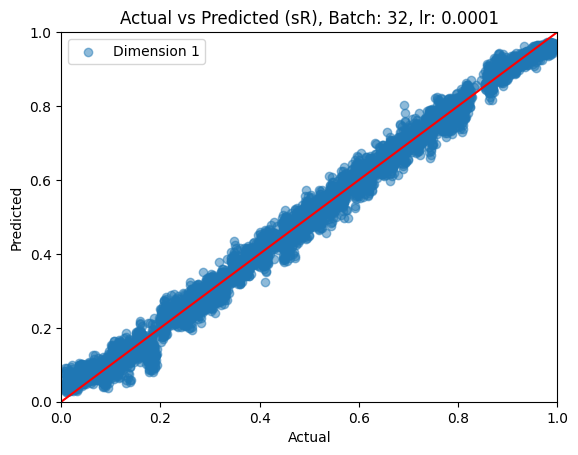

In [23]:
plt.scatter(target_test_n[:, 0], out[:, 0], label='Dimension 1', alpha=0.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Actual vs Predicted (sR), Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plotting a diagonal line for reference
p1 = max(out.max(), target_test_n.max())
p2 = min(out.min(), target_test_n.min())
plt.plot([p1, p2], [p1, p2], 'r-')

# Calculating R-squared for each dimension
R_square_dim1 = r2_score(target_test_n[:, 0], out[:, 0])

# Printing correlation coefficients for each dimension
s_corr_dim1, _ = spearmanr(target_test_n[:, 0], out[:, 0])
k_corr_dim1, _ = kendalltau(target_test_n[:, 0], out[:, 0])
p_corr_dim1, _ = pearsonr(target_test_n[:, 0], out[:, 0])

# Printing R-squared and correlation coefficients
print("R-squared for Dimension 1:", R_square_dim1)
print("Spearman rank correlation coefficient for Dimension 1:", s_corr_dim1)
print("Kendall rank correlation coefficient for Dimension 1:", k_corr_dim1)
print("Pearson rank correlation coefficient for Dimension 1:", p_corr_dim1)

# Save results to a file
file_name = '/content/drive/MyDrive/Neural Network for Pore Formation/GNN/1shell_10.txt'
with open(file_name, 'a') as file:
    file.write('\n')
    file.write(f"R-squared for Dimension 1: {R_square_dim1}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 1: {s_corr_dim1}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 1: {k_corr_dim1}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 1: {p_corr_dim1}\n")

# Save the plot
plt.savefig(f'1shell_{cutoff_radius}_result_dim1.png', bbox_inches='tight')
plt.show()

R-squared for Dimension 2: 0.7576798038574911
Spearman rank correlation coefficient for Dimension 2: 0.7522695371829443
Kendall rank correlation coefficient for Dimension 2: 0.5687414332749612
Pearson rank correlation coefficient for Dimension 2: 0.8706526794679568


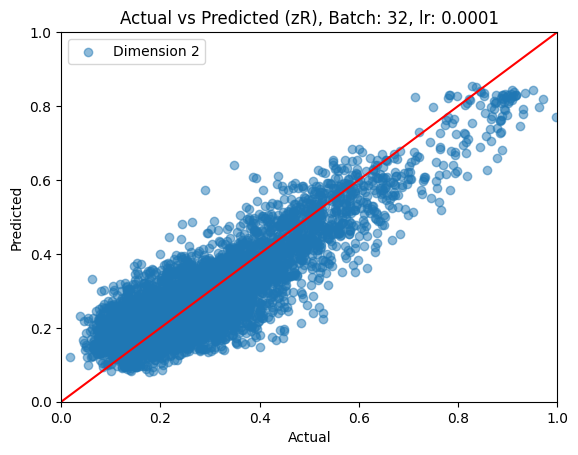

In [24]:
plt.scatter(target_test_n[:, 1], out[:, 1], label='Dimension 2', alpha=0.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Actual vs Predicted (zR), Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plotting a diagonal line for reference
p1 = max(out.max(), target_test_n.max())
p2 = min(out.min(), target_test_n.min())
plt.plot([p1, p2], [p1, p2], 'r-')

# Calculating R-squared for each dimension
R_square_dim2 = r2_score(target_test_n[:, 1], out[:, 1])

# Printing correlation coefficients for each dimension
s_corr_dim2, _ = spearmanr(target_test_n[:, 1], out[:, 1])
k_corr_dim2, _ = kendalltau(target_test_n[:, 1], out[:, 1])
p_corr_dim2, _ = pearsonr(target_test_n[:, 1], out[:, 1])

# Printing R-squared and correlation coefficients
print("R-squared for Dimension 2:", R_square_dim2)
print("Spearman rank correlation coefficient for Dimension 2:", s_corr_dim2)
print("Kendall rank correlation coefficient for Dimension 2:", k_corr_dim2)
print("Pearson rank correlation coefficient for Dimension 2:", p_corr_dim2)

# Save results to a file
file_name = '/content/drive/MyDrive/Neural Network for Pore Formation/GNN/1shell_10.txt'
with open(file_name, 'a') as file:
    file.write('\n')
    file.write(f"R-squared for Dimension 2: {R_square_dim2}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 2: {s_corr_dim2}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 2: {k_corr_dim2}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 2: {p_corr_dim2}\n")

# Save the plot
plt.savefig(f'1shell_{cutoff_radius}_result_dim2.png', bbox_inches='tight')
plt.show()

R-squared for Dimension 3: 0.9492869251681783
Spearman rank correlation coefficient for Dimension 3: 0.9461021530021687
Kendall rank correlation coefficient for Dimension 3: 0.8182095540938898
Pearson rank correlation coefficient for Dimension 3: 0.9743878670893548


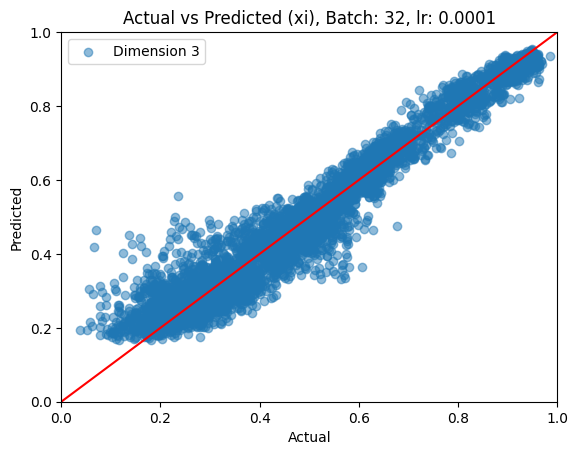

In [25]:
plt.scatter(target_test_n[:, 2], out[:, 2], label='Dimension 3', alpha=0.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Actual vs Predicted (xi), Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plotting a diagonal line for reference
p1 = max(out.max(), target_test_n.max())
p2 = min(out.min(), target_test_n.min())
plt.plot([p1, p2], [p1, p2], 'r-')

# Calculating R-squared for each dimension
R_square_dim3 = r2_score(target_test_n[:, 2], out[:, 2])

# Printing correlation coefficients for each dimension
s_corr_dim3, _ = spearmanr(target_test_n[:, 2], out[:, 2])
k_corr_dim3, _ = kendalltau(target_test_n[:, 2], out[:, 2])
p_corr_dim3, _ = pearsonr(target_test_n[:, 2], out[:, 2])

# Printing R-squared and correlation coefficients
print("R-squared for Dimension 3:", R_square_dim3)
print("Spearman rank correlation coefficient for Dimension 3:", s_corr_dim3)
print("Kendall rank correlation coefficient for Dimension 3:", k_corr_dim3)
print("Pearson rank correlation coefficient for Dimension 3:", p_corr_dim3)

# Save results to a file
file_name = '/content/drive/MyDrive/Neural Network for Pore Formation/GNN/1shell_10.txt'
with open(file_name, 'a') as file:
    file.write('\n')
    file.write(f"R-squared for Dimension 3: {R_square_dim3}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 3: {s_corr_dim3}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 3: {k_corr_dim3}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 3: {p_corr_dim3}\n")

# Save the plot
plt.savefig(f'1shell_{cutoff_radius}_result_dim3.png', bbox_inches='tight')
plt.show()

R-squared for Dimension 4: 0.9344870983652228
Spearman rank correlation coefficient for Dimension 4: 0.9249234294453009
Kendall rank correlation coefficient for Dimension 4: 0.7786610696373066
Pearson rank correlation coefficient for Dimension 4: 0.9667046655394936


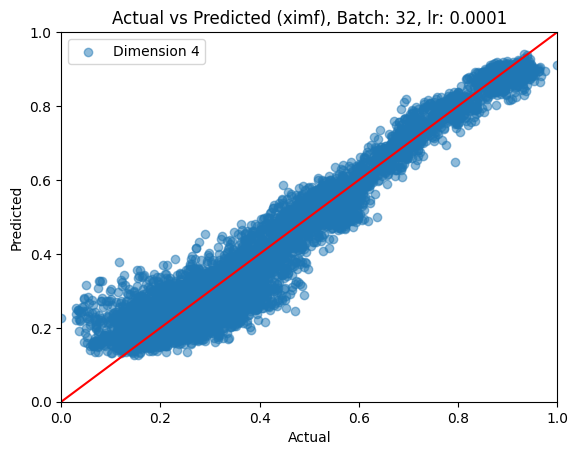

In [26]:
plt.scatter(target_test_n[:, 3], out[:, 3], label='Dimension 4', alpha=0.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Actual vs Predicted (ximf), Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plotting a diagonal line for reference
p1 = max(out.max(), target_test_n.max())
p2 = min(out.min(), target_test_n.min())
plt.plot([p1, p2], [p1, p2], 'r-')

# Calculating R-squared for each dimension
R_square_dim4 = r2_score(target_test_n[:, 3], out[:, 3])

# Printing correlation coefficients for each dimension
s_corr_dim4, _ = spearmanr(target_test_n[:, 3], out[:, 3])
k_corr_dim4, _ = kendalltau(target_test_n[:, 3], out[:, 3])
p_corr_dim4, _ = pearsonr(target_test_n[:, 3], out[:, 3])

# Printing R-squared and correlation coefficients
print("R-squared for Dimension 4:", R_square_dim4)
print("Spearman rank correlation coefficient for Dimension 4:", s_corr_dim4)
print("Kendall rank correlation coefficient for Dimension 4:", k_corr_dim4)
print("Pearson rank correlation coefficient for Dimension 4:", p_corr_dim4)

# Save results to a file
file_name = '/content/drive/MyDrive/Neural Network for Pore Formation/GNN/1shell_10.txt'
with open(file_name, 'a') as file:
    file.write('\n')
    file.write(f"R-squared for Dimension 4: {R_square_dim4}\n")
    file.write(f"Spearman rank correlation coefficient for Dimension 4: {s_corr_dim4}\n")
    file.write(f"Kendall rank correlation coefficient for Dimension 4: {k_corr_dim4}\n")
    file.write(f"Pearson rank correlation coefficient for Dimension 4: {p_corr_dim4}\n")

# Save the plot
plt.savefig(f'1shell_{cutoff_radius}_result_dim4.png', bbox_inches='tight')
plt.show()

In [28]:
params = list(model.parameters())

In [35]:
summary(model, input_size=(3072,3))

TypeError: GCN.forward() missing 2 required positional arguments: 'edge_index' and 'B'

In [29]:
print(params)
print()

[Parameter containing:
 tensor([[-0.0506, -0.1769,  0.0858],
         [-0.3296,  0.2987,  0.0581],
         [ 0.1960, -0.5136, -0.4768],
         [-0.3335,  0.1258, -0.2293],
         [-0.5105, -0.2231, -0.2824],
         [-0.4608, -0.5499, -0.3114],
         [-0.3651,  0.1641, -0.3214],
         [ 0.4460, -0.2133,  0.3122],
         [-0.1589, -0.0071,  0.2367],
         [ 0.5381,  0.4868,  0.2748],
         [ 0.3472, -0.3975, -0.0283],
         [-0.5050, -0.0136, -0.5358],
         [-0.5714, -0.5107,  0.5074],
         [-0.5622,  0.4888, -0.5244],
         [-0.2303, -0.2373,  0.4015],
         [-0.0558,  0.4544, -0.3664],
         [ 0.2515,  0.3270, -0.0452],
         [-0.4318, -0.0396, -0.5726],
         [ 0.5043,  0.1654,  0.1757],
         [-0.0289, -0.5482, -0.3338],
         [ 0.0902,  0.5655,  0.3199],
         [-0.2358, -0.5220, -0.3775],
         [ 0.2190, -0.1462, -0.0268],
         [ 0.5703,  0.0754,  0.4543],
         [ 0.3012,  0.1608, -0.5699]], device='cuda:0', requires_

In [33]:
last_layer_weights_fc3 = params[-2].data
print("Weights of the last layer (fc3):")
print(last_layer_weights_fc3)

Weights of the last layer (fc3):
tensor([[ 0.0106, -0.0202, -0.0041,  ..., -0.0122, -0.0034,  0.0062],
        [-0.0088, -0.0157, -0.0063,  ...,  0.0061,  0.0195,  0.0294],
        [-0.0094, -0.0172, -0.0157,  ..., -0.0111,  0.0201, -0.0010],
        [-0.0375, -0.0225, -0.0187,  ...,  0.0038, -0.0011,  0.0121]],
       device='cuda:0')


In [37]:
last_layer_weights_fc3_t = last_layer_weights_fc3.t()
weights_sum_abs = torch.abs(last_layer_weights_fc3_t).sum(dim=0)
print(weights_sum_abs)

tensor([33.2988, 34.7662, 30.5041, 32.1474], device='cuda:0')


In [38]:
last_layer_weights_fc3_t = last_layer_weights_fc3.t()
weights_sum = last_layer_weights_fc3_t.sum(dim=0)
print(weights_sum)

tensor([-3.4655, -2.2024,  0.6204, -1.5504], device='cuda:0')
